In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=036fd71d2558f65761cbe2377d863ce7f38eabf5a1e920b648718f7d99b0ac57
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [2]:
import pandas as pd
import numpy as np
from urllib.request import urlretrieve
import requests, zipfile, io, os
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
import utils
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot as plt

dataset = "https://archive.ics.uci.edu/static/public/519/heart+failure+clinical+records.zip"

r = requests.get(dataset)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("/heart")

In [10]:
print(os.listdir('/heart'))
df = pd.read_csv('/heart/heart_failure_clinical_records_dataset.csv',sep=",")
print(df.shape)
df.head()

['heart_failure_clinical_records_dataset.csv']
(299, 13)


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


# **EDA**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [ ]:
df.describe()

In [5]:
numerical_columns = df.select_dtypes(include=['float', 'int'])
summary_statistics = numerical_columns.describe()
print("Summary Statistics:\n", summary_statistics)

df.dtypes

Summary Statistics:
               age     anaemia  creatinine_phosphokinase    diabetes  \
count  299.000000  299.000000                299.000000  299.000000   
mean    60.833893    0.431438                581.839465    0.418060   
std     11.894809    0.496107                970.287881    0.494067   
min     40.000000    0.000000                 23.000000    0.000000   
25%     51.000000    0.000000                116.500000    0.000000   
50%     60.000000    0.000000                250.000000    0.000000   
75%     70.000000    1.000000                582.000000    1.000000   
max     95.000000    1.000000               7861.000000    1.000000   

       ejection_fraction  high_blood_pressure      platelets  \
count         299.000000           299.000000     299.000000   
mean           38.083612             0.351171  263358.029264   
std            11.834841             0.478136   97804.236869   
min            14.000000             0.000000   25100.000000   
25%            30.0

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

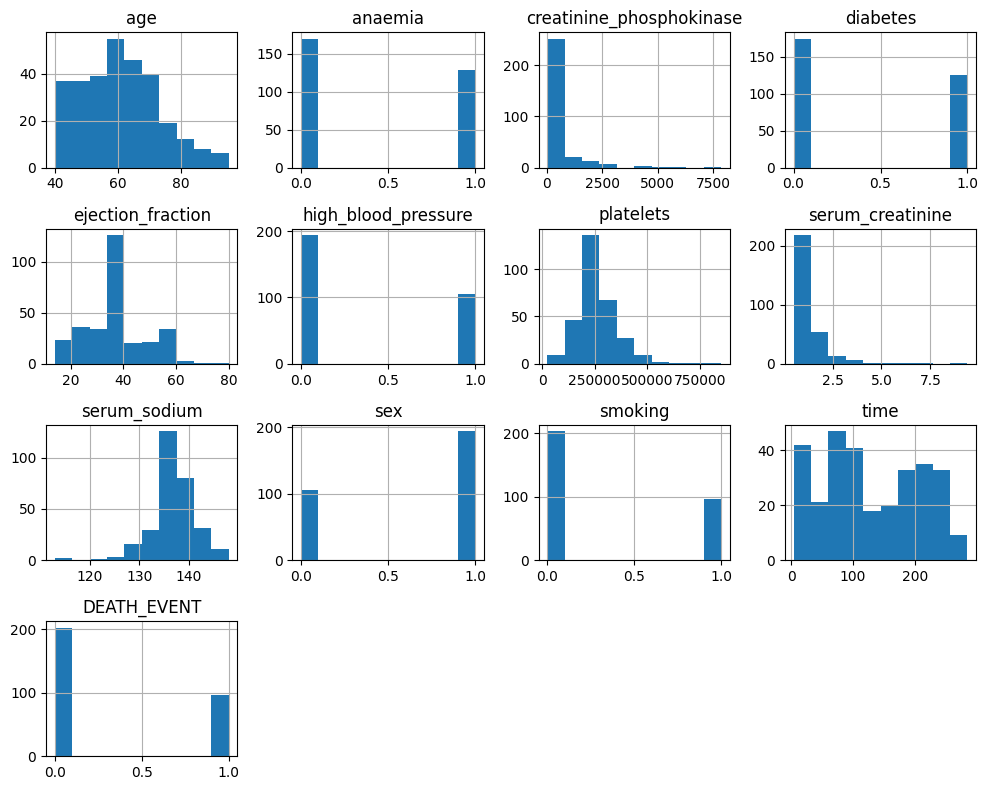

Number of Actual Clusters 2


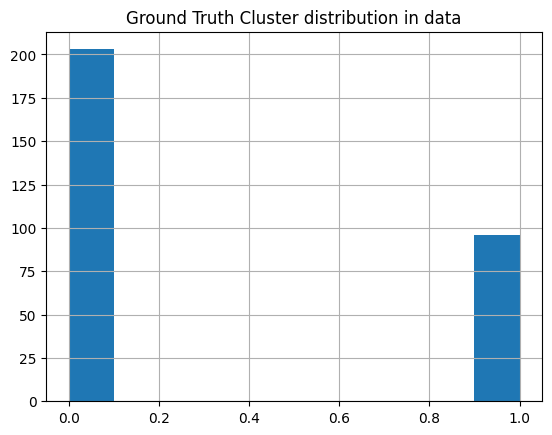

In [6]:
# Distribution of numerical variables
numerical_columns = df.select_dtypes(include=['float', 'int'])
numerical_columns.hist(bins=10, figsize=(10, 8))
plt.tight_layout()
plt.show()

print(f"Number of Actual Clusters {len(df['DEATH_EVENT'].unique())}")

df['DEATH_EVENT'].hist()
plt.title("Ground Truth Cluster distribution in data")
plt.show()

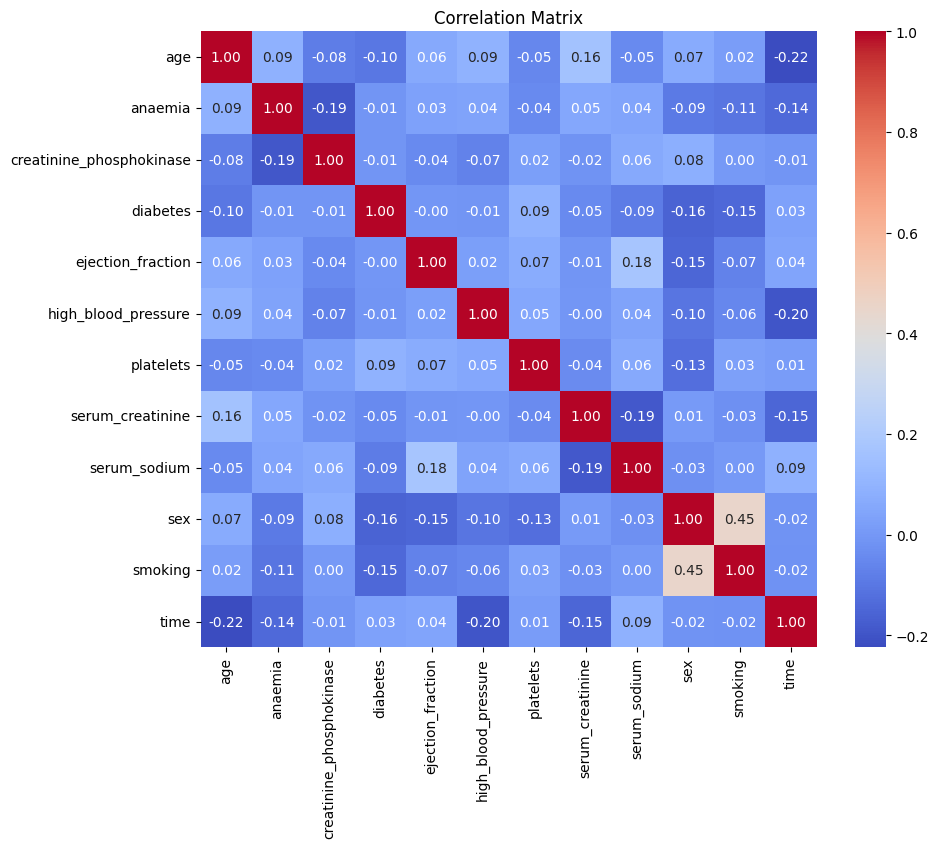

In [7]:
# Create correlation matrix between numerical features
correlation_matrix = df.drop('DEATH_EVENT', axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Find closely correlated features -
upper_triangle = np.triu(correlation_matrix, k=1)

# Find indices of correlations above the threshold
row_indices, col_indices = np.where(np.abs(upper_triangle) >= 0.95)

# Get the values and their corresponding row/column names
close_correlations = upper_triangle[row_indices, col_indices]
close_features = [(correlation_matrix.index[row], correlation_matrix.columns[col]) for row, col in zip(row_indices, col_indices)]
close_features

# **Format Dataset**

In [11]:
print(f'df shape before removing null rows: {df.shape}')
df = df.dropna()
print(f'df shape after removing null rows: {df.shape}')

# Separate the ground truth column
ground_truth = df.pop('DEATH_EVENT')

# Scale numeric columns
numeric_columns = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']
numeric_df = df[numeric_columns]
df = df.drop(numeric_columns, axis=1)
scaled_df = utils.standard_scaler(numeric_df)

# Concatenate scaled numeric columns and remaining columns
df = pd.concat([scaled_df, df], axis=1)

# Display the resulting DataFrame
df.head()

df shape before removing null rows: (299, 13)
df shape after removing null rows: (299, 13)
the dataframe is of shape(299, 7)
Number of numerical columns 7


/content/utils.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,anaemia,diabetes,high_blood_pressure,sex,smoking
0,1.192945,0.000166,-1.530560,1.681648e-02,0.490057,-1.504036,-1.629502,0,0,1,1,0
1,-0.491279,7.514640,-0.007077,7.535660e-09,-0.284552,-0.141976,-1.603691,0,0,0,1,0
2,0.350833,-0.449939,-1.530560,-1.038073e+00,-0.090900,-1.731046,-1.590785,0,0,0,1,1
3,-0.912335,-0.486071,-1.530560,-5.464741e-01,0.490057,0.085034,-1.590785,1,0,0,1,0
4,0.350833,-0.435486,-1.530560,6.517986e-01,1.264666,-4.682176,-1.577879,1,1,0,0,0


Working on KMeans


 36%|███▋      | 29/80 [13:04<22:54, 26.94s/it]

100%|██████████| 80/80 [35:43<00:00, 26.79s/it]


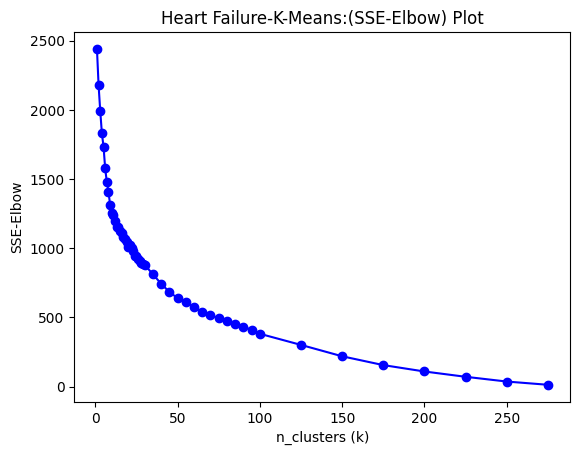

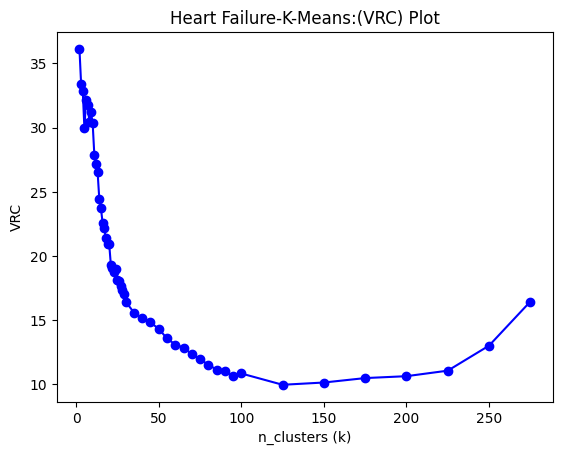

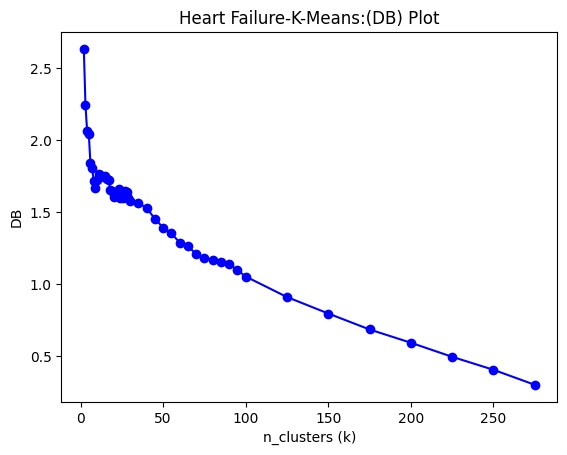

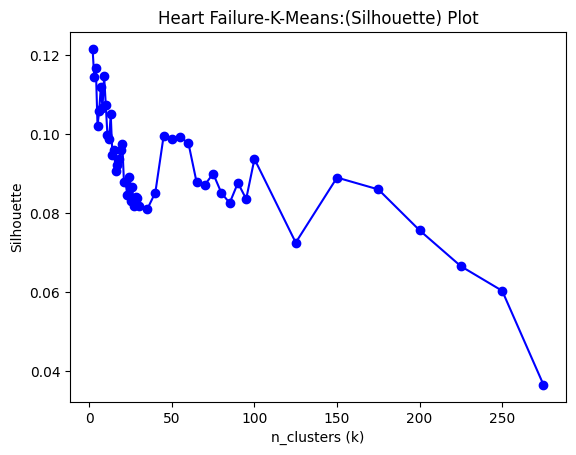

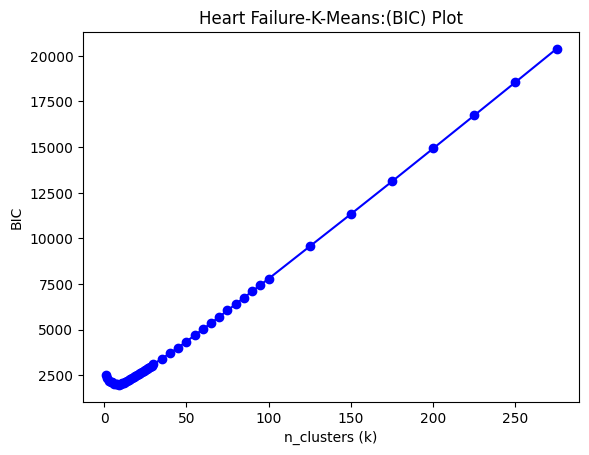

Working on DBSCAN


 80%|████████  | 16/20 [07:43<01:55, 28.87s/it]

100%|██████████| 20/20 [09:39<00:00, 28.97s/it]


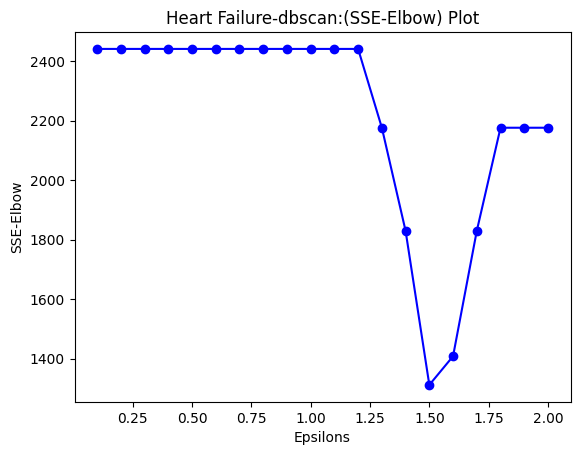

Working on OPTICS


 55%|█████▌    | 11/20 [05:40<04:39, 31.06s/it]

100%|██████████| 20/20 [10:27<00:00, 31.39s/it]


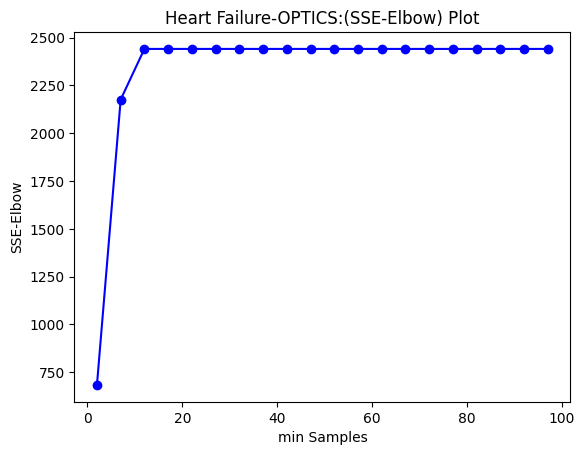

Working on AgglomerativeClustering


 20%|██        | 4/20 [02:06<08:22, 31.43s/it]

 55%|█████▌    | 11/20 [06:03<04:57, 33.03s/it]

 90%|█████████ | 18/20 [09:53<01:05, 32.55s/it]

100%|██████████| 20/20 [11:01<00:00, 33.09s/it]


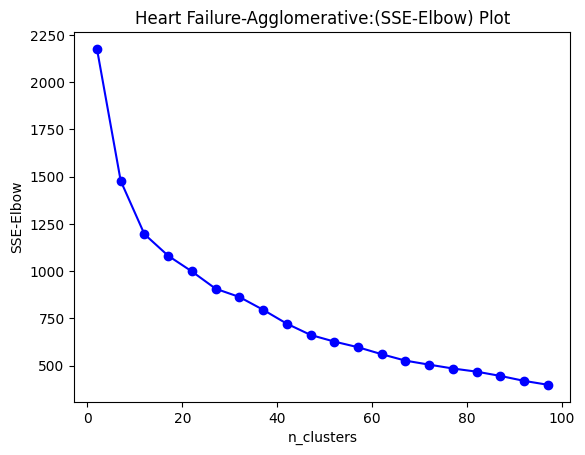

In [16]:
# Add ground truth column to save preprocessed data frame for submission
df['ground_truth'] = ground_truth
df.to_csv('Preprocessed data - Heart Failure', index=True)
num_of_clusters = df['ground_truth'].unique()
print(len(num_of_clusters))

# remove ground truth column and start calculations
ground_truth = df.pop('ground_truth')
df.head()
utils.calc_scores_for_all(df, 'Heart Failure')
